# Model Training
Train a machine learning model based on the land use/cover map and NAIP imagery in Philadelphia.

By Luming Xu, May 5, 2025
## Prepare the dataset for training

In [1]:
import os, os.path
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
from rasterio.enums import Resampling

#### Resample the raster data to the same spatial resolution

In [2]:
root = 'C:/Users/19397/Documents/GitHub/MUSA_6950/NationalParks_AI'
# NAIP imagery of Phiadelphia
naipfile = os.path.join(root, 'data/masked_naip_2017_philly.tif')
# Land use/cover map of Philadelphia
lufile = os.path.join(root, 'data/landcover_2018_philly.tif')

# Define file paths, here we resample the lu file with the NAIP imagery
source_raster = lufile  # The raster to be resampled
target_raster = naipfile  # The reference raster (desired resolution)
output_raster = os.path.join(root, "data/lu_resample.tif")  # The output file

# Open the reference raster to get its transform and resolution
ref = rasterio.open(target_raster) 
target_transform = ref.transform
target_crs = ref.crs
target_res = ref.res  # Resolution (pixel size)

# Open the source raster to resample
src= rasterio.open(source_raster)
# Read source data
src_data = src.read(1)  # Read the first band
source_transform = src.transform

# # Define the new transform and size based on the target raster
# new_transform = target_transform
# Update the transform with new resolution but keep the same extent
new_transform = rasterio.transform.Affine(
    target_res[0], source_transform.b, source_transform.c,
    source_transform.d, -target_res[1], source_transform.f
)

# Compute new raster size (preserve extent, only change resolution)
new_width = int((src.width * src.res[0]) / target_res[0])
new_height = int((src.height * src.res[1]) / target_res[1])

# Perform resampling
resampled_data = src.read(
    out_shape=(1, new_height, new_width),  # Match target shape
    resampling= Resampling.nearest# Resampling.bilinear  # Choose resampling method, we 
)

## to make sure the resample geotiff also colorful
color_interpretation = src.colorinterp
colormap = src.colormap(1)  # Extract color table (only for 1-band rasters)

# Update metadata for the output raster
new_meta = src.meta.copy()
new_meta.update({
    "driver": "GTiff",
    "height": new_height,
    "width": new_width,
    "transform": new_transform,
    "crs": target_crs,  # Match CRS,
    "count": 1,  # Ensure single band
    "compress": 'lzw'
})

# Save the resampled raster
with rasterio.open(output_raster, "w", **new_meta) as dst:
    dst.write(resampled_data)
    
    # just to write the color scheme, make sure the output tiff also has color, from chatgpt
    dst.colorinterp = color_interpretation
    dst.write_colormap(1, colormap)  # Apply original colormap
    
print("Resampling completed successfully!")


ValueError: NULL color table

#### Find the common region of LU and NAIP

In [ ]:
from rasterio.coords import BoundingBox
lu_dataset = rasterio.open(os.path.join(root, "data/lu_resample.tif"))
naip_dataset = rasterio.open(naipfile)
naip_bounds = naip_dataset.bounds
lulc_bounds = lu_dataset.bounds
# Find intersection (common area)
common_bounds = BoundingBox(
    max(lulc_bounds.left, naip_bounds.left),
    max(lulc_bounds.bottom, naip_bounds.bottom),
    min(lulc_bounds.right, naip_bounds.right),
    min(lulc_bounds.top, naip_bounds.top),
)

print("\nCommon Bounds (Overlapping Area):", common_bounds)


Common Bounds (Overlapping Area): BoundingBox(left=2660575.1551, bottom=204815.7006, right=2750111.1679, top=304939.8064)


In [ ]:
from rasterio.mask import mask
from pyproj import Transformer


def clip_raster(input_raster, output_raster, common_bounds, reference_crs):
    with rasterio.open(input_raster) as src:
        # Ensure bounds are in the same CRS
        src_crs = src.crs
        if src_crs != reference_crs:
            aligned_bounds = Transformer.transform_bounds(reference_crs, src_crs,
                                              common_bounds.left, common_bounds.bottom,
                                              common_bounds.right, common_bounds.top)
        else:
            aligned_bounds = (common_bounds.left, common_bounds.bottom, common_bounds.right, common_bounds.top)

        # Preserve color interpretation and colormap (for LU map)
        color_interpretation = src.colorinterp
        colormap = src.colormap(1) if src.count == 1 else None  # Only for single-band rasters

        # Convert bounds to a polygon mask
        bbox = [{
            "type": "Polygon",
            "coordinates": [[
                [aligned_bounds[0], aligned_bounds[1]],
                [aligned_bounds[0], aligned_bounds[3]],
                [aligned_bounds[2], aligned_bounds[3]],
                [aligned_bounds[2], aligned_bounds[1]],
                [aligned_bounds[0], aligned_bounds[1]]
            ]]
        }]

        # Clip the raster using mask()
        out_image, out_transform = mask(src, bbox, crop=True)

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "compress": "lzw"
        })

        # Save clipped raster
        with rasterio.open(output_raster, "w", **out_meta) as dst:
            dst.write(out_image)
            dst.colorinterp = color_interpretation  # Preserve color interpretation
            if colormap:
                dst.write_colormap(1, colormap)  # Preserve original colormap
    
    print(f"Clipped raster saved as {output_raster} with dimensions: {out_image.shape[2]} x {out_image.shape[1]}")
    

# Define input raster paths
lulc_path = os.path.join(root, "data/lu_resample.tif")
naip_path = os.path.join(root, 'data/masked_naip_2017_philly.tif')

# Define output paths
clipped_lulc_path = os.path.join(root, 'data/lulc_clipped.tif')
clipped_naip_path = os.path.join(root, 'data/naip_clipped.tif')

# Get reference CRS from NAIP
with rasterio.open(naip_path) as ref:
    reference_crs = ref.crs

# Apply clipping to both LU and NAIP
clip_raster(lulc_path, clipped_lulc_path, common_bounds, reference_crs)
clip_raster(naip_path, clipped_naip_path, common_bounds, reference_crs)


Clipped raster saved as C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/lulc_clipped.tif with dimensions: 27281 x 30507
Clipped raster saved as C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/naip_clipped.tif with dimensions: 27280 x 30506


In [2]:
# Open NAIP raster
with rasterio.open(clipped_naip_path) as naip:
    naip_data = naip.read()  # Read all bands
    naip_meta = naip.meta  # Store metadata

# Open Land Use raster (labels)
with rasterio.open(clipped_lulc_path) as land_use:
    land_use_data = land_use.read(1)  # Read land use as single-band raster
    land_use_meta = land_use.meta

naip_meta, land_use_meta

NameError: name 'clipped_naip_path' is not defined

#### Use resample again to erase the 1 pixel difference in the dimension

In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

# File paths
naip_path = clipped_naip_path
land_use_path = clipped_lulc_path
resampled_land_use_path = os.path.join(root, 'data/land_use_resampled.tif')

# Open the NAIP raster (reference)
with rasterio.open(naip_path) as naip:
    naip_transform = naip.transform
    naip_crs = naip.crs
    naip_res = naip.res  # Get resolution
    naip_width, naip_height = naip.width, naip.height

# Open the Land Use raster
with rasterio.open(land_use_path) as land_use:
    land_use_data = land_use.read(1)
    
    # Create an empty array to store resampled land use data
    resampled_land_use_data = np.empty((naip_height, naip_width), dtype=land_use_data.dtype)

    # Resample land use raster to match NAIP resolution & size
    rasterio.warp.reproject(
        source=land_use_data,
        destination=resampled_land_use_data,
        src_transform=land_use.transform,
        src_crs=land_use.crs,
        dst_transform=naip_transform,
        dst_crs=naip_crs,
        dst_resolution=naip_res,
        resampling=Resampling.nearest  # Use nearest-neighbor for categorical data
    )
    
    # Update metadata for new raster
    new_meta = land_use.meta.copy()
    new_meta.update({
        "driver": "GTiff",
        "height": naip_height,
        "width": naip_width,
        "compress": "lzw",
        "transform": naip_transform,
        "crs": naip_crs
    })

    # Save the resampled land use raster
    with rasterio.open(resampled_land_use_path, "w", **new_meta) as dst:
        dst.write(resampled_land_use_data, 1)

print("Resampled Land Use raster saved with matching dimensions to NAIP!")

Resampled Land Use raster saved with matching dimensions to NAIP!


In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

# File paths
clipped_naip_path = os.path.join(root, 'data/masked_naip_2017_philly.tif')
# naip_path = clipped_naip_path
# land_use_path = clipped_lulc_path
resampled_land_use_path = os.path.join(root, 'data/land_use_resampled.tif')

# Open NAIP raster
with rasterio.open(clipped_naip_path) as naip:
    naip_data = naip.read()  # Read all bands
    naip_meta = naip.meta  # Store metadata

# Open Land Use raster (labels)
with rasterio.open(resampled_land_use_path) as land_use:
    land_use_data = land_use.read(1)  # Read land use as single-band raster
    land_use_meta = land_use.meta

naip_meta, land_use_meta

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': None,
  'width': 27280,
  'height': 30506,
  'count': 4,
  'crs': CRS.from_epsg(2272),
  'transform': Affine(3.282111906158346, 0.0, 2660575.1551,
         0.0, -3.2821119058545856, 304939.8064)},
 {'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 27280,
  'height': 30506,
  'count': 1,
  'crs': CRS.from_epsg(2272),
  'transform': Affine(3.282111906158346, 0.0, 2660575.1551,
         0.0, -3.2821119058545856, 304939.8064)})

### 1.2 Building the Training Data for `scikit-learn`

In [4]:
import random
from sklearn.model_selection import train_test_split

# Get unique land use classes (ignoring NoData values like -9999 or 0)
unique_classes = np.unique(land_use_data)
unique_classes = unique_classes[unique_classes > 0]  # Remove NoData (0)

# Set the number of pixels per class (adjust for your needs)
samples_per_class = 500  # Reduce further if still too large

# Lists to store sampled data
X_list, y_list = [], []

# Sample pixels for each land use class
for lc in unique_classes:
    # Get all pixels of this land use class
    rows, cols = np.where(land_use_data == lc)
    
    # Randomly select 'samples_per_class' pixels if available
    sample_indices = random.sample(range(len(rows)), min(samples_per_class, len(rows)))
    
    for i in sample_indices:
        r, c = rows[i], cols[i]
        X_list.append(naip_data[:, r, c])  # Extract NAIP pixel values
        y_list.append(lc)  # Corresponding land use class

# Convert to NumPy arrays
X = np.array(X_list)  # Shape (num_samples, num_bands)
y = np.array(y_list)  # Shape (num_samples,)

# Split into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Final dataset size: {len(X_train)} training samples, {len(X_test)} test samples")

Final dataset size: 2450 training samples, 1050 test samples


In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


# Define classifiers
models = {
    "SVM": SVC(kernel="rbf"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "k-NN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naïve Bayes": GaussianNB()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{name}: Accuracy = {accuracy:.4f}")

SVM: Accuracy = 0.5048
Random Forest: Accuracy = 0.4829
k-NN: Accuracy = 0.4895
Decision Tree: Accuracy = 0.4229
Naïve Bayes: Accuracy = 0.4533


In [6]:
import joblib
import random
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
import joblib
import random
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Get unique land use classes (ignoring NoData values like -9999 or 0)
unique_classes = np.unique(land_use_data)
unique_classes = unique_classes[unique_classes > 0]  # Remove NoData (0)

# Set the number of pixels per class (adjust for your needs)
samples_per_class = 500  # Reduce further if still too large

# Lists to store sampled data
X_list, y_list = [], []

# Sample pixels for each land use class
for lc in unique_classes:
    # Get all pixels of this land use class
    rows, cols = np.where(land_use_data == lc)
    
    # Randomly select 'samples_per_class' pixels if available
    sample_indices = random.sample(range(len(rows)), min(samples_per_class, len(rows)))
    
    for i in sample_indices:
        r, c = rows[i], cols[i]
        X_list.append(naip_data[:, r, c])  # Extract NAIP pixel values
        y_list.append(lc)  # Corresponding land use class

# Convert to NumPy arrays
X = np.array(X_list)  # Shape (num_samples, num_bands)
y = np.array(y_list)  # Shape (num_samples,)

# Normalize the pixel values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Feature Selection (Select top 10 features based on ANOVA F-statistic)
selector = SelectKBest(score_func=f_classif, k=4)
X = selector.fit_transform(X, y)

# Split into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define classifiers
models = {
    "SVM": SVC(kernel="rbf", class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced"),
    "k-NN": KNeighborsClassifier(weights="distance"),
    "Decision Tree": DecisionTreeClassifier(),
    "Naïve Bayes": GaussianNB()
}

# Hyperparameter grid for each model (for GridSearchCV)
param_grid = {
    "SVM": {"C": [1, 10, 100], "gamma": ["scale", "auto"]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]},
    "k-NN": {"n_neighbors": [3, 5, 7], "metric": ["euclidean", "manhattan"]},
    "Decision Tree": {"max_depth": [None, 10, 20], "min_samples_split": [2, 10]},
    "Naïve Bayes": {"var_smoothing": [1e-9, 1e-8, 1e-7]}
}

# Dictionary to store the accuracy results
accuracy_results = {}
# Train and evaluate each model using GridSearchCV for hyperparameter tuning and cross-validation
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(model, param_grid[name], cv=5, n_jobs=-1, scoring="accuracy")
    grid_search.fit(X_train, y_train)
    print(f"Best Params for {name}: {grid_search.best_params_}")
    print(f"Best Accuracy (from GridSearchCV) for {name}: {grid_search.best_score_:.4f}")

    # Use the best model from GridSearchCV to make predictions and evaluate
    best_model = grid_search.best_estimator_
    accuracy = best_model.score(X_test, y_test)
    accuracy_results[name] = accuracy
    print(f"Accuracy on test set for {name}: {accuracy:.4f}")

    # Save the best model for later use
    if name == "SVM":  # Save the best model (SVM) or any other model you want to use for prediction
        joblib.dump(best_model, "C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/best_svm_model.pkl")
        print(f"Saved the best model as 'best_svm_model.pkl'.")

    # Cross-validation scores for the model
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="accuracy")
    print(f"Cross-validation Accuracy for {name}: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Additional evaluation metrics
    from sklearn.metrics import classification_report, confusion_matrix
    y_pred = best_model.predict(X_test)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))

# Display the accuracy results of all models
print("\nModel Accuracy Results:")
for name, accuracy in accuracy_results.items():
    print(f"{name}: Accuracy = {accuracy:.4f}")



Training SVM...
Best Params for SVM: {'C': 100, 'gamma': 'scale'}
Best Accuracy (from GridSearchCV) for SVM: 0.5376
Accuracy on test set for SVM: 0.5571
Saved the best model as 'best_svm_model.pkl'.
Cross-validation Accuracy for SVM: 0.5376 (+/- 0.0207)
Classification Report for SVM:
              precision    recall  f1-score   support

           1       0.59      0.71      0.64       150
           2       0.44      0.49      0.47       150
           3       0.61      0.34      0.44       150
           4       0.86      0.89      0.87       150
           5       0.47      0.56      0.51       150
           6       0.47      0.63      0.54       150
           7       0.50      0.28      0.36       150

    accuracy                           0.56      1050
   macro avg       0.56      0.56      0.55      1050
weighted avg       0.56      0.56      0.55      1050

Confusion Matrix for SVM:
[[106  16   9   4   8   4   3]
 [ 43  74  12   0  12   7   2]
 [  9  39  51   1  16  18  16

In [7]:
from sklearn.svm import SVC

# Train an SVM Classifier (RBF Kernel for non-linear decision boundaries)
svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

## 2 Predicting on the image

In [8]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

### 2.1 Apply the trained model to four tiles of Chicago

In [9]:
# Load the saved model
# best_model_svm = joblib.load("C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/best_svm_model.pkl")
# print("Loaded the best SVM model.")

import os
# from sklearn.externals import joblib  # Load the trained model
# Define input and output directories
input_dir = "C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/CT-naip"
output_dir = "C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/CT-classified"
os.makedirs(output_dir, exist_ok=True)

# Load trained classification model (update path to your model file)
# model_path = "path_to_your_trained_model.pkl"
# model = joblib.load(model_path)

# Loop through all TIFF files in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, f"classified_{filename}")
        
        with rasterio.open(input_path) as src:
            img = src.read()
            meta = src.meta
            reshaped_img = reshape_as_image(img)
            
            # Predict class labels
            class_prediction = svm_model.predict(reshaped_img.reshape(-1, img.shape[0]))
            class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)
            
            # Update metadata and save classified raster
            meta.update(dtype=rasterio.uint8, count=1)
            with rasterio.open(output_path, "w", **meta) as dst:
                dst.write(class_prediction.astype(rasterio.uint8), 1)
        
        print(f"Processed {filename} and saved to {output_path}")

print("Classification completed for all tiles.")

Processed mask2022-naip.tif and saved to C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/CT-classified\classified_mask2022-naip.tif
Classification completed for all tiles.


### 2.2 Plot

Unique values in the classified raster: [2 6]
NoData value: None


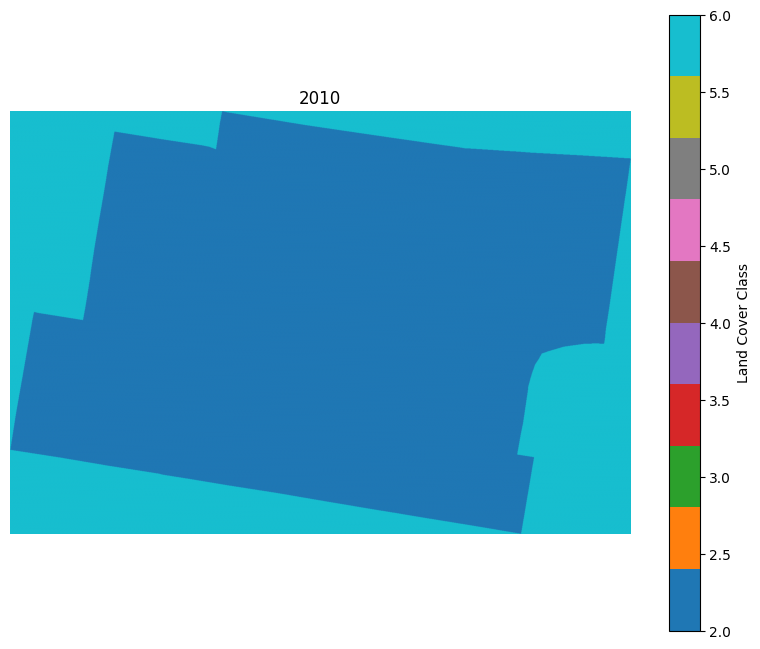

In [1]:
import rasterio
from matplotlib import pyplot as plt
import numpy as np

mosaic_path = 'C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/CT-classified/classified_mask2017-naip.tif'

# Open the raster file
with rasterio.open(mosaic_path) as src:
    classified_img = src.read(1)  # Read the first (only) band
    nodata_value = src.nodata  # Check the NoData value, if exists

# Check unique values in the raster (to understand classification)
print(f"Unique values in the classified raster: {np.unique(classified_img)}")
print(f"NoData value: {nodata_value}")

# Handle NoData values (e.g., replace them with a specific value if needed)
if nodata_value is not None:
    classified_img[classified_img == nodata_value] = 0  # Replace NoData with 0 or any appropriate value

# Plot the classified raster
# Plot the classified raster
plt.figure(figsize=(10, 8))
plt.imshow(classified_img, cmap="tab10")  # 'tab10' provides distinct colors
plt.colorbar(label="Land Cover Class")  # Optional colorbar
plt.title("2010")
plt.axis("off")  # Hide axis ticks
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train an SVM Classifier (RBF Kernel for non-linear decision boundaries)
svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

## Compute NDVI

In [ ]:
import rio
out_tif = 'C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/CT-data/CT-veg.tif'

infolder = 'C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/CT-naip'
outfolder = 'C:/Users/19397/Documents/GitHub/MUSA_6950/ai-urban-sustainability/lab6-machine-learning/CT-data'

if not os.path.exists(outfolder):
    os.mkdir(outfolder)


for file in os.listdir(infolder):
    tiffile = os.path.join(infolder, file)
    
    # read the different bands of the raster data
    if not tiffile.endswith('.tif'): continue
    naip_dataset = rio.open(tiffile)
    green = np.float32(naip_dataset.read(3))
    red = np.float32(naip_dataset.read(2))
    nir = np.float32(naip_dataset.read(1))

    # here add 0.0000001 is to make sure the nir+red is not zero
    ndvi = (nir - red)/(nir + red + 0.000001)
    
    # extract the vegetation based on the ndvi
    veg = np.zeros((ndvi.shape[0], ndvi.shape[1]), dtype = np.uint16)
    veg[ndvi > 0] = 1
    
    
    # prepare the schema of the new tiles
    out_meta = naip_dataset.meta.copy()

    # update the schema of the ndvi image, because it is different from teh raw naip image, like only one band
    out_meta.update({'count': 1,
                    'dtype': 'uint16',
                     "height": ndvi.shape[0],
                     "width": ndvi.shape[1],
    #                  "transform": out_transform,
                     "crs": naip_dataset.crs, 
                     'compress': 'lzw'}
                   )
    
    
    # this is required, because rio will use three dimension, even this is single band image
    veg = veg.reshape(1, veg.shape[0], veg.shape[1])
    
    out_tif = os.path.join(outfolder, file)
    with rio.open(out_tif, "w", **out_meta) as dest:
        dest.write(veg)
    

### 2.3 Visualize the land use map using GIS desktop
![Classified Land Use Map](landuse.png)